$\textbf{Rahul Roy Chowdhury}$
    <br>
$\text{s214002}$ 
   <br>
**$12^{\text{th}} \, \text{December} \, 2022$**
<br>
$\text{Technical University of Denmark}$
<br>
$\textit{Department of Electrical and Photonics Engineering}$

# Comparision of a Conventional Direction of Arrival algorithm to a Neural-Network based model


Estimation in the Direction of Arrival (DoA) depends on the acoustics of an enclosure and the array geometry of the receiver, among other factors. From the factors that affect the estimation of DoA we consider only the reverberation time of the room ($T_{60}$), the signal to noise ratio, the geometry of the room, the orientation of the receiver and the position of the source. Conventional DoA algorithms are based on signal processing techniques that rely on phase information between sensor elements or other physically motivated techniques such as those that rely on wave propagation . When subjected to reverberation and noise, these algorithms often fail to locate the sound source. This is where neural network based models tend to be useful, as they are capable of extracting important features which are often unattainable by common signal processing practices and this enables them to perform far better under harsh conditions, **P. Grumiaux** [2022]. This notebook illustrates the findings of a project undertaken within the timespan of three months and is limited to simulated acoustic environments, closely emulating various acoustic conditions by utilising the image source method (ISM) for small enclosures **H. Kuttruff** [2009]. For more information, please refer to README.txt.

# Table of Contents

- [Section 1: Method](#Section1)
    - [1.1: Conventional Model](#Section1.1)
    - [1.2: Neural Network Model](#Section1.2)
- [Section 2: Parameter Selection](#Section2)
    - [2.1: Single Room](#Section2.1)
    - [2.2: General Room](#Section2.2)
- [Section 3: Generating Room Impluse Responses](#Section3)
- [Load Data](#DataLoad)
- [Section 4: Steered Response Power](#Section4)
- [Section 5: Convolutional Neural Network](#Section5)
    - [5.1: Building the model](#Section5.1)
    - [5.2: Training and Testing](#Section5.2)
- [Section 6: Simulation Results](#Section6)
- [Section 7: Conclusion](#Section7)
- [References](#Section8)

<a id='Section1'></a>
## Section 1: Method

The notebook begins by introducing the parameters of a room required to obtain room impulse responses (RIR), by default the parameters are set to model similar conditions to that of Room 019 in Building 352, Technical University of Denmark. The motivation behind this test was to see how well a conventional algorithm would perform for a realistic room in comparision to a neural network model which has been trained with RIR data from the given room. Section 2 is responsible in setting the parameters for generating the RIR dataset. Section 3 contains the conventional algorithm which takes RIR measurements and estimates the direction of arrival. Section 4 is the Neural Network model which learns the important features of the RIR and returns an estimate of the accuracy. *If data has already been stored and saved, Sections 1,2 & 3 should be skipped and one should start from Load Data.* 

<a id='Section1.1'></a>
### 1.1: Conventional model: Steered Response Power

Steered Response Power is a method of beamforming based on acoustic power mapping. The weighted SRP is given as:

<div align="center"> $P(x) = \frac{1}{2\pi} \sum_{m_1 = 1}^{M} \sum_{m_2 = 1}^{M} \int_{-\pi}^{\pi}{\Phi_{m_1,m_2}(e^{j\omega}) S_{m_1}(e^{j\omega}) S_{m_2}^{*}(e^{j\omega}) e^{j\omega\tau_{m_1,m_2}(x)} d\omega}$
<br><br>
    
Here, M represents the number of microphones, $S_m(e^{j\omega})$ is the DTFT of $s_m(n)$, which is the signal recorded from the microphone. The term $\tau_{m_1,m_2}$ is the discrete time difference of arrival of a signal emitted from position $\textbf{x}$ to the microphones $m_1 \, \& \, m_2$. $\Phi_{m_1,m_2}(e^{j\omega})$ is a frequency domain weighting function. The SRP function can be effectively expressed as a sum of Generalized Cross-Correlations for different microphone pairs at the given time difference of arrival. The source location is estimated by finding the maximum of $P(x)$, for a specific pre-defined candidate source locations. Modifications to the model have been made to reduce **computational complexity** and **increase robustness**, one such example is the SRP-PHAT (Steered Response Power - Phase Transform), **J. DiBiase** [2000]. For each microphone pair and each grid point, a unique value of TDOA is selected to be the acoustic delay corresponding to that point. Both these algorithms will be compared with the neural network model.

<a id='Section1.2'></a>
### 1.2: Neural Network based model: Convolutional Neural Network

The architecture of the neural network is based around a convolutional layer followed by some dense layers. Convolutional neural networks are very powerful since they possess the property of translational invariance, which means that the output is unaffected by shift in data. In addition to this, one way to compare signals in signal processing terms is to look at the correlation, which is similar to convolution as it estimates the time delay by finding the maximum in the cross-power spectrum. The RIRs generated are processed into the fourier domain and the phase coefficients are extracted and used for training the model. Since we are concerned with the delay of signals, the magnitude information is not of relevance for our model. The output of the neural network is expected to classify the sound source into a fixed number of regions in the azimuth plane. *It is worth noting that the elevation plane is disregarded for this project, due to increased complexity.* For example, if there are 8 possible regions, then the azimuth plane is divided into 45 degree segments. For further simplicity, the output is one-hot encoded such that the output will consist of a vector of zeros and only a single value of 1.

<a id='Section2'></a>
## Section 2: Parameter Selection

<a id='Section2.1'></a>
### 2.1 Input Parameters for Single Room

In [25]:
import numpy as np
import pyroomacoustics as pra
""" added following lines to silence tf warnings"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from Package import *
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import time
import math
from IPython.display import Image
from tqdm import tqdm, tqdm_notebook

The impulse response of the room can be used to estimate the direction of the source relative to the array. Studies have revealed the advantages in having sparse sensor arrays for DoA estimation, **Muqaibal, A.** [2021]. However, for this study, a linear microphone array has been used due its simplicity and the ease with which the number of microphones and their positions can be manipulated. The variable below selects the number of microphones.

In [2]:
n_mics = 4
# number of microphones in a linear array configuration

The next thing to keep in mind is the geometry of the room. The dimensions of the room can vary depending on the nature of the simulation, whether it is an office room being modelled, or something larger like a classroom. For simplicity, a shoebox model has been used, and as mentioned above, the dimensions set as default is based on that of Room 019.

In [3]:
first_corner  = np.array([0., 0.])
second_corner = np.array([0., 4.])
third_corner  = np.array([6., 4.])
fourth_corner = np.array([6., 0.])
# corners of the room in meters

room_height   = 3
# height of the room in meters

Above, it was mentioned that two factors which contribute to a decreased sound source localization for conventional algorithms. One is the reverberation time, RT60, defined as the time taken for the sound pressure level to decrease by 60 dB. A highly reverberant room has a $T_{60}$ value close to 1 to 2 seconds. **It is worth noting that this value heavily depends on the volume of the room specified above.** A large room cannot really have a low reverberant time. The other factor is the signal to noise ratio, there is no reference value, but from tests shown below, 25 dB can be considered to be a fairly high SNR measurement. 

In [4]:
rt60          = 0.5
# reverberation time in seconds

snr           = 25
# signal to noise ratio in dB

One directly controllable parameter of the Image Source Method is the maximum order of image sources that can be used for modelling the impulse response. *Increasing this parameter can take the model longer to extract the IR.* The last parameter for extraction of IR is the number of runs. **It is worth mentioning that the microphone is always placed in the middle of the room, the source position is what changes during every run, the exact implementation of this can be found under computeRIR().** It is important to consider this variable when training the NN model. The nTrunc variable decides how much of the impulse response should be kept, i.e. how long it will be in seconds.

In [5]:
max_order = 10
# maximum order of image sources (increasing 
# this affects the computational time)

nRuns = 250
# number of times the IR is recorded with n_mics

nTrunc = 0.2
# amount of which the IR will be truncated to: IR = IR(:nTrunc*fs)
# if nTrunc = 0.2 s, fs = 16000, then the IR length is 3200 samples

The last parameter for the single room test is an analogous way to discretize and classify the output. As we will see later, the neural network architecture is based around classifying the output to a certain region in $2\pi$ space. By dividing this space into nDivisions, the model is able to decide which direction the sound is coming from and classify it, instead of providing the user with a rough estimate in the form of an exact angle.

In [6]:
nDivisions    = 8
# resolution of the output
# angular resolution = 360 / nDivisions

<a id='Section2.2'></a>
### 2.2 Input Parameters for General Room

This section is for generating a dataset that has varying parameters, such as the reverberation time, the signal to noise ratio and the dimensions of the room. The minimum and maximum values of these parameters are stored in an array in the format [min, max]. 

In [7]:
rt60_gen      = [0.2, 0.6]
# boundaries of reverberation time (seconds)

snr_gen       = [15, 40]
# boundaries of signal to noise ratio (dB)

length        = [6, 10]
width         = [4, 6]
# boundaries of length and width (meters) 

The three variables below determine whether the reverberation time, the signal to noise ratio is in fact varied at all or not. If one is set to **False**, then the value will be fixed with the Single Room variable. The orientation of the microphone here refers to the fact that the microphone will still stay in the center of the room, however the array will be rotated about the origin during each run randomly.  

In [8]:
vary_mic      = False
# option to vary microphone orientation

vary_rt60     = True
# option to vary reverberation time

vary_snr      = True
# option to vary signal to noise ratio

The final parameter determines how many room dimensions are tested. **This must be set to 1 when investigating the single room condition, otherwise the geometry of the room will change depending on the number of dimensions specified.** For example, if nRuns = 50 and nDimensions = 10, this means that there will be 50 runs for each room geometry, and there will be 10 different geometries, resulting in 500 runs overall.

In [9]:
nDimensions   = 12
# number of unique dimensions to be tested 
# total runs = nDimensions * nRuns

<a id='Section3'></a>
## Section 3: Generating Room Impulse Responses

The first thing to do is to initialize the output variables. 
- <code>RIR_Phase = [len_Phase, n_mics, nRuns * nDimensions]</code> is a matrix consisting of the phase information of the impulse response across all frequencies for each microphone and each run.
- <code>RIR = [len_RIR, n_mics, nRuns * nDimensions]</code> is a matrix consisting of the impulse response
- <code>angles = [nRuns * nDimensions]</code> is a vector consisting of the direction of the sound source for each run
- <code>one_hot_output = [nDivisions, n_mics, nRuns * nDimensions]</code> is the encoded version of the <code>angles</code> matrix which will be used to train the CNN model.

In [10]:
fs = 16000
len_RIR = int(fs * nTrunc)
len_Phase = int(fs * nTrunc/2)

RIR = [[[0 for _ in range(len_RIR)] for _ in range(n_mics)] for _ in range(nRuns*nDimensions)]
angles = [0 for _ in range(nRuns*nDimensions)]
one_hot_output = [[[0 for _ in range(nDivisions)] for _ in range(n_mics)] for _ in range(nRuns*nDimensions)]

l_delta = length[1] - length[0]
# Difference in max and min size of length

w_delta = width[1] - width[0]
# Difference in max and min size of width

index = 0
# index is used to store the data for each run

As mentioned in Section 1.2, the input to the CNN model will be the Phase information for each frequency bin. Since we are using a microphone array, there will be an associated lower and upper frequency limit that the microphones will be able to resolve without ambiguity. The lower limit can be attributed to the frequency corresponding to wavelength that is double the distance between the two farthest microphones. Frequencies far below this limit will not be resolved correctly since the microphones may not pick up the variation in pressure due to large wavelengths. The upper limit ensures that spatial aliasing does not occur. The highest frequency a microphone can faithfully recover is limited by the inter-microphone distance. If $f = c/\lambda$, and $\lambda \geq 2\cdot \Delta r $, then $f \leq \frac{c}{2\cdot \Delta r}$, where $\Delta r$ is the spacing between two adjacent microphones **J. Dmochowski** [2009]. Removing the frequencies outside the range reduces redundancy and ambiguity.

In [11]:
x_array = np.linspace(-.1, .1, n_mics)
y_array = np.linspace(-.00, .00, n_mics)
z_array = np.linspace(-.00, .00, n_mics)

min_distance = np.sqrt((x_array[0] - x_array[1])**2 + (y_array[0] - y_array[1])**2 + (z_array[0] - z_array[1])**2)
max_distance = np.sqrt((x_array[0] - x_array[-1])**2 + (y_array[0] - y_array[-1])**2 + (z_array[0] - z_array[-1])**2)

c = 343   # speed of sound in air

max_freq = c / (2*min_distance)
min_freq = c / (2*max_distance)

print(min_freq, max_freq)

lower_index, upper_index = index_gen(len_RIR, min_freq, max_freq, fs)

RIR_Phase = [[[0 for _ in range(upper_index-lower_index)] for _ in range(n_mics)] for _ in range(nRuns*nDimensions)]

for S in range(0, nDimensions):

    # S refers to the index for a specific room dimension, for the single room test, this will run only once
    
    if vary_mic:
        
        x_array, y_array, z_array = mic_orientation(n_mics)
        # mic_orientation() returns the positions of a random line in 3D
        # corresponding to a different orientation during each run.

    if nDimensions != 1:
        
        first_corner = np.array([0., 0.])
        second_corner = np.array([0., round(width[0] + w_delta * np.random.rand(),2)])
        third_corner = np.array([round(length[0] + (l_delta) * np.random.rand(),2), second_corner[1]])
        fourth_corner = np.array([third_corner[0], 0.])
        # if the user opts to vary the dimensions of the room, then the dimensions are randomly varied, 
        # within the range specified by the user. 
        
    if vary_rt60:
        rt60 = rt60_gen[0] + (rt60_gen[1] - rt60_gen[0])*np.random.rand()
        # varying the room reverberation
    
    for R in tqdm(range(0, nRuns)):
        
        if vary_snr:
            
            snr = snr_gen[0] + np.random.rand()*(snr_gen[1] - snr_gen[0])
            # varying the signal to noise ratio
            
        RIR[index], RIR_Phase[index], angles[index], one_hot_output[index] = computeRIR(first_corner, second_corner, third_corner, fourth_corner,
                      room_height, max_order, nDivisions, n_mics, rt60, snr, len_RIR,  x_array, y_array, z_array, lower_index, upper_index)
        index += 1

857.5 2572.5


100%|█████████████████████████████████████████| 250/250 [00:59<00:00,  4.17it/s]


In [12]:
DATA = {"Phase": np.asarray(RIR_Phase),"Output": np.asarray(one_hot_output), "RIR": np.asarray(RIR), "Angles": np.asarray(angles), "nDivisions":nDivisions,
       "n_mics":n_mics, "Total_Runs":nRuns*nDimensions}
# The data is stored in a dictionary format, consisting of the Phase, the Impulse Response, 
# the One Hot Encoded DoA, the actual angles, and the configuration settings

The data is then stored for repeatability and to ensure that the data does not get erased.

In [13]:
fileName = "Data/Generalization_Test.npz"
np.savez(fileName, **DATA)

<a id='DataLoad'></a>
### Load Data

In [26]:
%reset
# When prompted, type 'y' and enter to clear the variables in the workspace

import numpy as np
from Package import *

fileName = "Data/Generalization_Test.npz"
DATA = np.load(fileName, allow_pickle= True)
print([key for key in DATA.keys()])

total_Runs = DATA["Total_Runs"]
nDivisions = DATA["nDivisions"]
n_mics = DATA["n_mics"]

IR = DATA["RIR"]
angles = DATA["Angles"]
phase_info = DATA["Phase"]
direction = DATA["Output"]

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


['Phase', 'Output', 'RIR', 'Angles', 'nDivisions', 'n_mics', 'Total_Runs']


<a id='Section4'></a>
## Section 4: Steered Response Power - Phase Transform

Once the simulation has been run and the data has been saved, the notebook can be closed or reset to remove the output variables as this will free up memory for the following processing stages. In order to compute the accuracy of the SRP algorithm and the CNN model, only Section 2 needs to be re-run. The parameters for the function calculateSRP includes the file consisting of impulse responses, the number of divisions to be made, the number of microphones used for the capturing of RIR and finally the total number of runs (nRuns * nDimensions). 

The output of this function is the accuracy of both SRP and SRP-PHAT. 

In [27]:
ac_srp, ac_srp_phat = calculateSRP(IR, angles, nDivisions, n_mics, total_Runs)
print(f"SRP accuracy: {ac_srp} %, SRP-PHAT accuracy: {ac_srp_phat} %")

SRP accuracy: 31.764038570618265 %, SRP-PHAT accuracy: 32.444696539988655 %


<a id='Section5'></a>
## Section 5: Convolutional Neural Network

The performance of the baseline (SRP / SRP-PHAT) can be compared to the CNN model which is shown below.

<a id='Section5.1'></a>
### 5.1: Building the Model

In [28]:
def build_model(input_shape, nAngles):

    # create model

    model = tf.keras.Sequential()

    # Convolutional Layer
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    model.add(tf.keras.layers.Conv1D(32, kernel_size = 25, activation = 'relu',
                                     kernel_regularizer = tf.keras.regularizers.l2(l2=1e-4), padding = 'same'))
    model.add(tf.keras.layers.Conv1D(32, kernel_size = 25, activation = 'relu',
                                     kernel_regularizer = tf.keras.regularizers.l2(l2=1e-4), padding = 'same'))
    model.add(tf.keras.layers.Dropout(0.2)) # CAN BE INCREASED
    model.add(tf.keras.layers.MaxPooling1D(strides = 2))

    # model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv1D(16, kernel_size = 25, activation = 'relu',
                                     kernel_regularizer = tf.keras.regularizers.l2(l2=1e-4), padding = 'same'))
    model.add(tf.keras.layers.Conv1D(16, kernel_size = 25, activation = 'relu',
                                     kernel_regularizer = tf.keras.regularizers.l2(l2=1e-4), padding = 'same'))
    model.add(tf.keras.layers.Dropout(0.1)) # CAN BE INCREASED
    model.add(tf.keras.layers.MaxPooling1D(strides = 2))
    # model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv1D(8, kernel_size = 25, activation = 'relu',
                                     kernel_regularizer = tf.keras.regularizers.l2(l2=1e-4), padding = 'same'))
    model.add(tf.keras.layers.Conv1D(8, kernel_size = 25, activation = 'relu',
                                 kernel_regularizer = tf.keras.regularizers.l2(l2=1e-4), padding = 'same'))
    model.add(tf.keras.layers.Dropout(0.1)) # CAN BE INCREASED

    model.add(tf.keras.layers.MaxPooling1D(strides = 2))
    # model.add(tf.keras.layers.Dropout(0.3))
    # model.add(tf.keras.layers.MaxPool1D(32, strides = 2, padding = 'same',name = 'MaxPool'))

    # Flatten Output of Convolutional Layers and Feed it into Dense Layer

    model.add(tf.keras.layers.Flatten(name = 'Flatten'))

    model.add(tf.keras.layers.Dense(256, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.5)) # CAN BE INCREASED

    model.add(tf.keras.layers.Dense(256, activation = "relu"))
    #model.add(keras.layers.Dense(256, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.4)) # CAN BE INCREASED

    # Output Layer which uses SoftMax

    model.add(tf.keras.layers.Dense(nAngles, activation = "softmax"))

    return model

<a id='Section5.2'></a>
### 5.2: Training and Testing

The first stage is to load the dataset and prepare the dataset into three categories, training data, test data and finally validation data. Test data is never used for training and this scheme is a form of cross validation which prioritizes the accuracy of generalization error. The prepare_datasets() function has three input parameters, the first is the percentage split of the training and the test data, while the second is the split of the validation and training data. If the latter one is set to 0.2 for example, this would mean that the model uses 5-Fold crossvalidation. The last input variable is the file containing the dataset.

In [29]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(phase_info, direction, 0.25, 0.2)
# create train, validation and test sets
X_train = X_train.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)
X_validation = X_validation.transpose(0,2,1)
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Input shape to neural network: {input_shape}  [Nsamples x Nmics]")
print(f"Total number of batches (different rooms) reserved for training: {X_train.shape[0]}")
print(f"Total number of batches (different rooms) reserved for testing: {X_test.shape[0]}")
print(f"Total number of batches (different rooms) reserved for validation: {X_validation.shape[0]}")
# input_shape is a vector consisting of the dimensions of X_train.

Input shape to neural network: (343, 4)  [Nsamples x Nmics]
Total number of batches (different rooms) reserved for training: 1800
Total number of batches (different rooms) reserved for testing: 750
Total number of batches (different rooms) reserved for validation: 450


The next stage is to build the architecture of the model, the function build_model does this and requires the shape of the input (training) data as well as the number of divisions (resolution). Then the optimizer is chosen, in this model Adam was used since it is a widely used modified version of the stochastic gradient descent algorithm , the parameter learning_rate refers to how rapid the optimizer should move at each iteration, also known as the **momentum**. The model is then compiled (model.compile) with the following parameters: 

- optimizer: optimizing algorithm of choice
- loss: which loss function should be used, this example is a multi-class classification problem, hence it is appropriate to use categorical cross entropy
- metrics: this parameter is optional and it displays the value of a metric upon each epoch (run) of the training. In this case, the accuracy of the model was chosen.

In [30]:
model = build_model(input_shape, nDivisions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay= 1e-4)

model.compile(optimizer=optimizer, 
                loss = "categorical_crossentropy",
                metrics = "CategoricalAccuracy")

# compile the network

Metal device set to: Apple M2


Finally, the model is fit with the training dataset and cross-validated with the validation set. This is done using the model.fit() function and it has the following parameters:
- X_train: Training input data, matrix containing phase information
- y_train: Training output data, matrix containing one-hot encoded direction in azimuth plane
- validation_data: Contains the validation dataset of input and output
- batch_size: Size of each training run before the network parameters are adjusted
- epochs: Number of times the network is trained with the full training dataset
- verbose: parameter which enables us to see the progress of the model, by default it is set to 1, if set to 0, *the progress will not be shown*. 

In [ ]:
# train the CNN network

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size = 300, epochs = 500, verbose = 1)

The trained model is then evaluated with the test dataset, model.evaluate():

- X_test: input test dataset consisting of the phase information
- y_test: output test dataset consisting of the one hot encoded directions
- verbose: parameter which enables us to see the progress of the model, by default it is set to 0, if set to 1, the progress can be seen.

In [20]:
# evaluate CNN on test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy on test set is: {}".format(test_accuracy))

24/24 [==============================] - 1s 30ms/step - loss: 1.4869 - categorical_accuracy: 0.5747
Accuracy on test set is: 0.5746666789054871


### Model Performance
The training and validation accuracy as well as generalization error over each iteration is shown below. This is extremely useful when analyzing the performance of the model and checking for overfitting. 

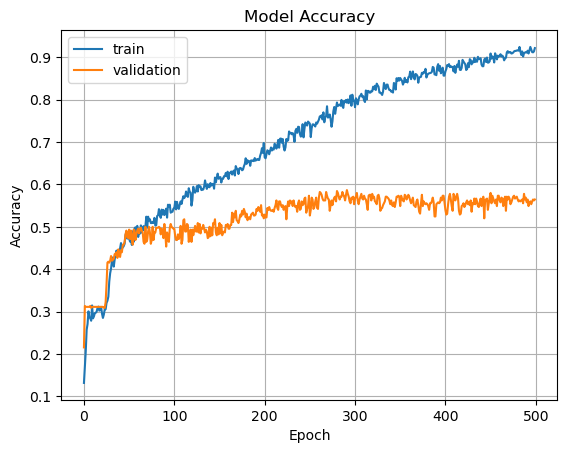

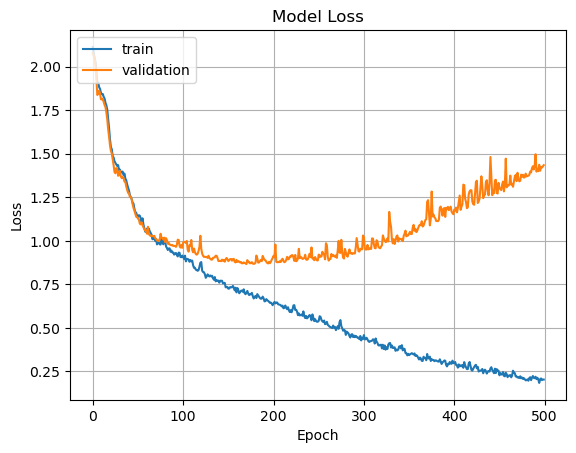

In [21]:
model_performance(history)

The user can verify the performance of the model by testing specific input data and visualizing the expected and model output. The output of the model typically takes the maximum of each direction to compute the DoA. Here, the predicted output is what the model provides before selecting the maximum. Due to the "softmax" function, the output is a probability distribution and hence the y axis in the plot is between 0 and 1. The actual output will always have a value of 1 (100% accuracy), but the predicted may not always give a value of 1 since it is a probability distribution.

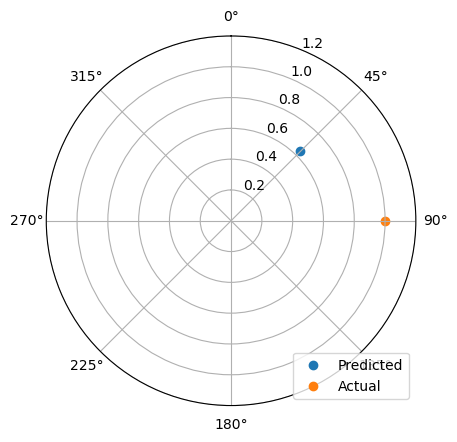

In [76]:
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))

r = np.linspace(0,360,nDivisions+1) * np.pi/180
# creating a linear space of 360 degrees for plotting the estimated and true directions

test = np.random.randint(1,len(X_test))
# testing index, by default it randomly picks a number from the test dataset

y_pred = model.predict(X_test[test:test+1], verbose = 0)
# this is the part where the model predicts for one dataset

y_actual = y_test[test]
# y_actual is the true direction


index_pred = np.where(y_pred == max(y_pred[0]))[1][0]

index_actual = np.where(y_actual == 1)

ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.scatter(r[index_pred], y_pred[0][index_pred], label="Predicted")
ax1.scatter(r[index_actual], y_actual[index_actual], label="Actual")
ax1.set_rlim(0,1.2)
ax1.legend(loc="lower right")

<a id='Section6'></a>
## Section 6: Simulation Results: Varying SNR ($T_{60}$ = 0.5s) and Varying $T_{60}$ (SNR = 25 dB)

The two figures below compare the performance of SRP, SRP-PHAT and CNN in varying noise and $T_{60}$ conditions. Here, the room size is kept **constant** ($4$m $\times 6$m $\times 3$m).  

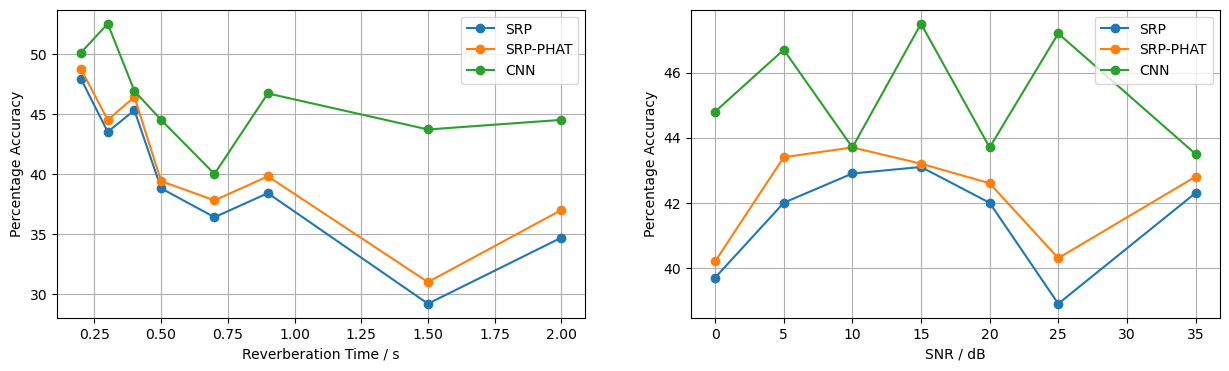

In [23]:
from matplotlib.pyplot import figure

vary_SNR = "Data/vary_SNR.npz"
DATA_SNR = np.load(vary_SNR, allow_pickle= True)
#print([key for key in DATA_SNR.keys()])

vary_RT = "Data/vary_RT.npz"
DATA_RT = np.load(vary_RT, allow_pickle= True)
#print([key for key in DATA_RT.keys()])

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(15, 4)

ax1.set_xlabel('Reverberation Time / s')
ax1.set_ylabel('Percentage Accuracy')
ax1.grid()

ax1.plot(DATA_RT['RT'], DATA_RT['SRP'],marker='o', label="SRP") 

ax1.plot(DATA_RT['RT'], DATA_RT['SRP_PHAT'], marker='o', label="SRP-PHAT") 

ax1.plot(DATA_RT['RT'], DATA_RT['CNN'], marker='o', label="CNN") 
ax1.legend()

ax2.set_xlabel('SNR / dB')
ax2.set_ylabel('Percentage Accuracy')
ax2.grid()

ax2.plot(DATA_SNR['SNR'], DATA_SNR['SRP'], marker='o', label="SRP") 

ax2.plot(DATA_SNR['SNR'], DATA_SNR['SRP_PHAT'], marker='o', label="SRP-PHAT") 

ax2.plot(DATA_SNR['SNR'], DATA_SNR['CNN'], marker='o', label="CNN") 
ax2.legend(loc="upper right")

<a id='Section7'></a>
## Section 7: Conclusion

The purpose of this course was to investigate the advantages in using a neural network based approach to estimating the direction of arrival of sound sources. The NN model was built based on a convolutional network architecture, and it was capable of estimating the DoA with an accuracy excess of 40% under certain conditions discussed above.

Looking at the performance of the models for varying SNR and Reverberation Time (Section 6), the SRP-PHAT algorithm appears to be slightly more accurate than the traditional SRP algorithm. When varying the reverberation time, all three models show a decreasing trend in accuracy, but this is far more evident for the conventional models, the neural network model varies around 45% accuracy, while the conventional models reach as low as 30%. This is expected, since a more reverberant room consists of far more reflections, thus making it very difficult to localize the sound source. For the SNR variation, the performance of the conventional models increase with the Signal to Noise ratio and stabilize around 42%. The CNN model is more robust to these conditions as it varies between 44% to 48%, still performing better than the conventional models. 

The performances of the models when using a generalized dataset (varying SNR, RT, room dimensions) can be summarized as follows. The CNN model achieved a staggering 57.5% accuracy when compared to the SRP algorithm which could only achieve an accuracy of 32%. Under these conditions, there was a clear indication of overfitting, since the amount of loss increased after about 100 epochs for the validation set, while the training set loss kept decreasing. When testing the model performance for a single room and varying noise and reverberation time, the convolutional neural network resulted in about 45% accuracy on average, thus indicating that the model performs better under varying conditions. An extension to this project could be to analyze the performance after increasing the number of divisions in the output. 

### Acknowledgements

I would like to thank my supervisors Xenofon Karakonstantis and Efren F. Grande for making this project feasible and enjoyable given the timing constraints. In addition to this, I would also like to thank the Acoustics department for providing support and assistance when required. 

<a id='Section8'></a>
# References:
- D. Diaz-Guerra, A. Miguel, and J. R. Beltran, “Robust sound source tracking using SRP-phat and 3d Convolutional Neural Networks,” IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 29, pp. 300–311, 2021. 
- I. Aboumahmoud, A. Muqaibel, M. Alhassoun, and S. Alawsh, “A review of sparse sensor arrays for two-dimensional direction-of-arrival estimation,” IEEE Access, vol. 9, pp. 92999–93017, 2021.
- J. DiBiase, “A High-Accuracy, Low-Latency Technique for Talker Localization in Reverberant Environments Using Microphone Arrays,” May 2000. 
- P.-A. Grumiaux, S. Kitić, L. Girin, and A. Guérin, “A survey of sound source localization with deep learning methods,” The Journal of the Acoustical Society of America, vol. 152, no. 1, pp. 107–151, 2022.  
- H. Kuttruff, Room Acoustics, Fifth Edition. CRC Press, 2009.
- J. Dmochowski, J. Benesty and S. Affes, "On Spatial Aliasing in Microphone Arrays," in IEEE Transactions on Signal Processing, vol. 57, no. 4, pp. 1383-1395, April 2009, doi: 10.1109/TSP.2008.2010596.